In [3]:
import os

from fastai.text import *
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', -1)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content'

In [6]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!ln -s "/gdrive/My Drive/SemEval_weights_data" "/content/"
drive_path = "/content/SemEval_weights_data/data/"
save_path = "/content/SemEval_weights_data/models"

try:
  os.chdir(drive_path)
  #os.chdir('/content/drive/My Drive/Colab Notebooks/semeval')
  print('Changed directory')
  print(os.getcwd())
except:
  print('Cannot change directory')
  print(os.getcwd())

Mounted at /gdrive
ln: failed to create symbolic link '/content/SemEval_weights_data': File exists
Changed directory
/gdrive/My Drive/SemEval_weights_data/data


## 1. Import the data

In [10]:
df_train = pd.read_csv(drive_path+'processed_train.csv')
df_test = pd.read_csv(drive_path+'processed_val.csv')
# df_train.head()
df_trn = df_train[['sentiment', 'text']].rename({'sentiment': 'label'}, axis=1)
df_val = df_train[['sentiment', 'text']].rename({'sentiment': 'label'}, axis=1)
df_trn.head()

,label,text
0,neutral,nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life ...
1,neutral,@nehantics Haan yaar neha :pensive_face::pensive_face: kab karega woh post :loudly_crying_face: Usne na sach mein photoshoot karna chahiye phir woh post karega
2,negative,@RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke
3,positive,@AmitShah @narendramodi All India me nrc lagu kare w Kashmir se dhara ko khatam kare ham Indian ko apse yahi umid hai
4,neutral,@Nehr_who @TypoMantri @anjanaomkashyap Pagal hai kya ? They aren ’ t real issues Mandir is important Hindu khatre mei jo hai !


## 2. Create train & validation datasets and FastAI data bunch

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [12]:
data_clas.show_batch()

text,target
xxbos @gurmeetramrahim : tulip : xxup dhan : tulip : xxup dhan : rose : xxup satguru : rose : : rose : xxup tera : rose : xxup hi : tulip : xxup aasra : tulip : g : folded_hands : : rose : xxup pyare : rose : xxup sohne : rose : xxup xxunk : rose : : rose : xxup mahi : rose : xxup rabb,neutral
xxbos xxup rt xxunk xxmaj what a xxmaj gorgeous xxmaj look xxmaj of xxmaj mah xxup xxunk xxmaj sooo xxmaj xxunk xxmaj xxunk xxmaj she xxmaj is : smiling_face_with_heart - eyes::smiling_face_with_heart - eyes::smiling_face_with_heart - eyes::smiling_face_with_heart - eyes::smiling_face_with_heart - eyes::smiling_face_with_heart - eyes::smiling_face_with_heart - eyes : xxmaj nazar xxmaj na xxmaj lag xxmaj jaaye xxmaj jaanu : face_blowing_a_kiss::face_blowing_a_kiss : xxmaj thought xxmaj ye xxmaj xxunk,neutral
xxbos xxup rt xxunk xxmaj xxunk xxup ab v ý rok xxmaj xxunk o xxunk z á xxunk ů odm í t á m odm í taj í ho m í pr á xxunk í ci . xxmaj pro č ? č ek á me na p xxunk xxunk a pak se xxunk á d xxunk me ? xxmaj ch á pe,neutral
xxbos xxup rt xxunk no one absolutely no one nctzens : xxunk : who : face_with_steam_from_nose::face_with_steam_from_nose : the xxup fuck : xxunk : made xxup our : xxunk : xxup pure xxup boy : xxunk - xxunk : xxup renjun : star - xxunk : xxunk xxup cry ? ! ? ! ? ! ? : xxunk - xxunk :,negative
xxbos xxup rt xxup xxunk xxup what xxup the xxup fuck ! ! ! xxup like xxup what xxup in xxup the xxup actual xxup fuck xxrep 4 ! xxmaj dila can ’ t die she can ’ t die there ’ s no xxmaj xxunk without xxmaj dila : loudly_crying_face::loudly_crying_face::loudly_crying_face : tell me it wa,negative


In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')
data_lm = load_data('./', 'data_lm_export.pkl')
data_clas = load_data('./', 'data_clas_export.pkl', bs=64)

## 3. Create and Train the Language Model

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 7.59E-02


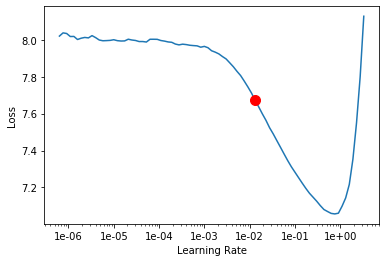

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [16]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.908895,4.982615,0.248329,00:24
1,5.106332,4.635746,0.275419,00:24


In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.575572,4.286129,0.310235,00:25
1,4.419355,4.203620,0.317062,00:26


In [18]:
learn.predict("How do", n_words=10)

"How do i n't worry ? ? ? Hundred_points :"

In [0]:
learn.save_encoder('ft_enc')

## 4. Using the Language Model to Train the Classifier

In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14000 items)
x: TextList
xxbos xxunk á xxunk xxunk xxunk xxunk xxunk xxunk ě lost xxunk ě j a xxunk jen xxunk xxmaj asi xxunk xxunk á m ů j life ...,xxbos xxunk xxmaj haan yaar neha : pensive_face::pensive_face : kab karega woh post : loudly_crying_face : xxmaj usne na sach mein xxunk karna chahiye phir woh post karega,xxbos @rahulgandhi television media congress ke liye nhi h . xxmaj ye toh aapko pata chal hi gya hoga . xxmaj achha hoga ki xxmaj congress ke,xxbos @amitshah @narendramodi xxmaj all xxmaj india me nrc lagu kare w xxmaj kashmir se dhara ko khatam kare ham xxmaj indian ko apse yahi umid hai,xxbos @nehr_who xxunk @anjanaomkashyap xxmaj pagal hai kya ? xxmaj they aren ’ t real issues xxmaj mandir is important xxmaj hindu khatre mei jo hai !
y: CategoryList
neutral,neutral,negative,positive,neutral
Path: .;

Valid: LabelList (14000 items)
x: TextList
xxbos xxunk á xxunk xxunk xxunk xxunk xxunk xxunk ě lost xxunk ě j a xxun

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-02


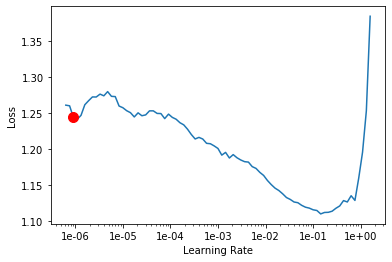

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [22]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.233921,1.180833,0.357929,00:21
1,1.224656,1.167201,0.365357,00:22


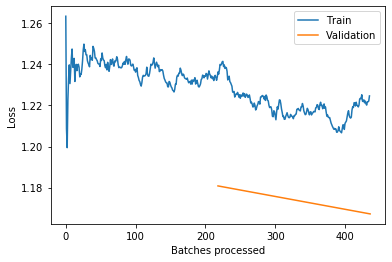

In [23]:
learn.recorder.plot_losses()

In [24]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.946528,0.841397,0.606500,00:24
1,0.899067,0.820705,0.613643,00:23
2,0.866520,0.763423,0.658500,00:22
3,0.816612,0.735430,0.677214,00:23


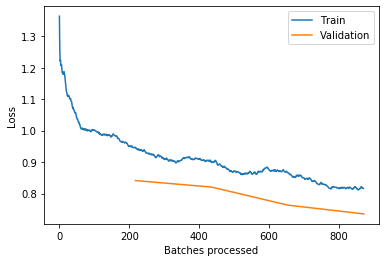

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.828828,0.725742,0.684000,00:24
1,0.809905,0.684392,0.709643,00:26
2,0.775947,0.628286,0.741214,00:25
3,0.721520,0.614705,0.748929,00:24


In [27]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.739011,0.603119,0.750929,00:24
1,0.741544,0.566484,0.770286,00:25
2,0.675860,0.496887,0.810929,00:24
3,0.629504,0.490201,0.813071,00:25


In [28]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.651999,0.482847,0.809071,00:25
1,0.664452,0.460198,0.827286,00:25
2,0.633138,0.404538,0.856071,00:24
3,0.598427,0.386405,0.863643,00:25


In [29]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.582876,0.379152,0.861786,00:24
1,0.598676,0.364651,0.873000,00:25
2,0.548100,0.311508,0.895857,00:25
3,0.519945,0.299222,0.899500,00:24


In [30]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524700,0.299945,0.901786,00:24
1,0.541711,0.291821,0.903357,00:26
2,0.503787,0.252224,0.926143,00:24
3,0.455294,0.229952,0.932214,00:24


In [31]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.487567,0.243088,0.927786,00:26
1,0.499658,0.236588,0.925786,00:25
2,0.448278,0.187213,0.949786,00:25
3,0.418542,0.175831,0.954429,00:25


## 5. Analyzing our results

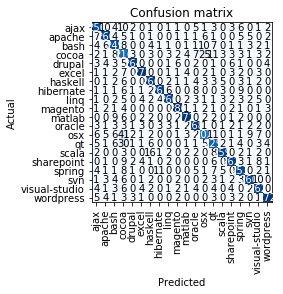

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
interp.most_confused()

[('osx', 'cocoa', 41),
 ('qt', 'cocoa', 30),
 ('cocoa', 'osx', 25),
 ('scala', 'haskell', 16),
 ('cocoa', 'qt', 11),
 ('osx', 'qt', 11),
 ('spring', 'hibernate', 11),
 ('ajax', 'apache', 10),
 ('ajax', 'cocoa', 10),
 ('bash', 'osx', 10),
 ('svn', 'visual-studio', 10),
 ('hibernate', 'spring', 9),
 ('matlab', 'bash', 9),
 ('osx', 'svn', 9),
 ('sharepoint', 'cocoa', 9),
 ('bash', 'cocoa', 8),
 ('cocoa', 'bash', 8),
 ('hibernate', 'oracle', 8),
 ('scala', 'qt', 8),
 ('sharepoint', 'visual-studio', 8),
 ('spring', 'cocoa', 8),
 ('apache', 'ajax', 7),
 ('bash', 'qt', 7),
 ('cocoa', 'oracle', 7),
 ('excel', 'cocoa', 7),
 ('osx', 'visual-studio', 7),
 ('spring', 'qt', 7),
 ('ajax', 'spring', 6),
 ('apache', 'osx', 6),
 ('bash', 'apache', 6),
 ('drupal', 'magento', 6),
 ('drupal', 'sharepoint', 6),
 ('haskell', 'cocoa', 6),
 ('hibernate', 'cocoa', 6),
 ('hibernate', 'linq', 6),
 ('matlab', 'cocoa', 6),
 ('osx', 'ajax', 6),
 ('osx', 'bash', 6),
 ('qt', 'bash', 6),
 ('qt', 'haskell', 6),
 ('shar

## 6. Predictions

In [44]:
learn.predict("@AhsanAh @SarfarazA_ Ahsan bhai Meri taraf se Best wishes di jye ga apnay bhai ko :Pakistan::green_heart:")

(Category neutral, tensor(1), tensor([6.7470e-04, 8.5731e-01, 1.4201e-01]))

## 7. Export the model

In [0]:
save_path = "/content/SemEval_weights_data/models/95.40-fastai"
learn.export(save_path)